# Supervised Machine Learning

The below code contains the SVM model and Logistic Regression model for the 1 year slice of time.

## Imports

These are the imports needed to fun this code. If anything is not allows to import, please !pip install accordingly.

In [1]:
# Import required libraries
import pandas as pd
from pathlib import Path
from pandas.tseries.offsets import DateOffset
import warnings
warnings.filterwarnings("ignore")
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

## Load Pre Processed data for 1 year Period

In [2]:
# Read
trading_df = pd.read_csv(
    Path('../../Data/ETF CSV files/Cost_and_volume_1yr.csv'), 
    index_col="time", 
    infer_datetime_format=True, 
    parse_dates=True)

# Review the Data-Frame
trading_df.head()

,Asia_50_Costs,JP_Morgan_USD_Emerging_Markets_Bond_AUD_Hedged_E_Costs,MSCI_Emerging_Markets_Costs,iShares_MSCI_South_Korea_ETF_Volume,close,Asia_50_Volume,JP_Morgan_USD_Emerging_Markets_Bond_AUD_Hedged_E_Volume,MSCI_Emerging_Markets_Volume,iShares MSCI South Korea ETF,volume
time,,,,,,,,,,
2021-06-30,122.51,101.64,73.74,124.50,105.5975,"7,339,280.00","450,833.00","13,790,240.00","817,950.00","5,599,575.75"
2021-07-01,122.51,101.64,73.74,124.50,105.5975,"7,339,280.00","450,833.00","13,798,640.00","818,763.00","5,601,879.00"
2021-07-02,121.32,100.23,73.13,124.85,104.8825,"7,348,226.00","451,669.00","13,821,162.00","820,963.00","5,610,505.00"
2021-07-05,120.54,100.27,72.92,124.18,104.4775,"7,348,226.00","451,669.00","13,678,362.00","822,063.00","5,575,080.00"
2021-07-06,119.89,100.28,72.53,123.76,104.1150,"7,348,226.00","451,669.00","13,678,362.00","821,290.00","5,574,886.75"


## Data Preparation

In [3]:
# Calculate the daily returns using the closing prices and the pct_change function
trading_df["actual_returns"] = trading_df["close"].pct_change()

# Define a window size of 4
short_window = 4

# Create a simple moving average (SMA) using the short_window and assign this to a new columns called sma_fast
trading_df["sma_fast"] = trading_df["close"].rolling(window=short_window).mean()

# Define a window size of 100
long_window = 100

# Create a simple moving average (SMA) using the long_window and assign this to a new columns called sma_slow
trading_df["sma_slow"] = trading_df["close"].rolling(window=long_window).mean()

# Drop all NaN values from the DataFrame
trading_df = trading_df.dropna()

# Assign a copy of the sma_fast and sma_slow columns to a new DataFrame called X
X = trading_df[["sma_fast", "sma_slow"]].copy()

# Create a new column in the trading_df called signal setting its value to zero.
trading_df["signal"] = 0.0

# Create the signal to buy
trading_df.loc[(trading_df["actual_returns"] >= 0), "signal"] = 1

# Create the signal to sell
trading_df.loc[(trading_df["actual_returns"] < 0), "signal"] = -1

# Copy the new signal column to a new Series called y.
y = trading_df["signal"].copy()

## Splitting the features and values

In [4]:
# Select the start of the training period
training_begin =  X.index.min()

# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=3)
X.index.min() + DateOffset(months=3)

# Create the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Create the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

# Create a StandardScaler instance
scaler = StandardScaler()
 
# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## SVM Model

In [5]:
# Create the classifier model
svm_model = svm.SVC()
 
# Fit the model to the data using X_train_scaled and y_train
svm_model = svm_model.fit(X_train_scaled, y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = svm_model.predict(X_train_scaled)

# Display the sample predictions
training_signal_predictions[:10]

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])

In [6]:
# Evaluate the model using a classification report
svm_training_report = classification_report(y_train, training_signal_predictions)

# Print the classification report for the SVM model using the training data
print("SVM Classification Report (training data)")
print(svm_training_report)

SVM Classification Report (training data)
              precision    recall  f1-score   support

        -1.0       0.66      0.89      0.76        35
         1.0       0.75      0.43      0.55        28

    accuracy                           0.68        63
   macro avg       0.70      0.66      0.65        63
weighted avg       0.70      0.68      0.66        63



In [7]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = svm_model.predict(X_test_scaled)

In [8]:
# Evaluate the model's ability to predict the trading signal for the testing data
svm_testing_report = classification_report(y_test, testing_signal_predictions)

# Print the classification report for the SVM model using the test data
print("SVM Classification Report (test data)")
print(svm_testing_report)

SVM Classification Report (test data)
              precision    recall  f1-score   support

        -1.0       0.60      0.88      0.71        57
         1.0       0.22      0.06      0.09        36

    accuracy                           0.56        93
   macro avg       0.41      0.47      0.40        93
weighted avg       0.45      0.56      0.47        93



## Logistic Regression Model

In [9]:
# Create an instance of the LogisticRegression model
logistic_regression_model = LogisticRegression()

# Fit the LogisticRegression model
logistic_regression_model.fit(X_train_scaled, y_train)

LogisticRegression()

In [10]:
# Use the trained LogisticRegression model to predict the trading signals for the training data
lr_training_signal_predictions = logistic_regression_model.predict(X_train_scaled)

# Display the predictions
lr_training_signal_predictions

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.])

In [11]:
# Generate a classification report using the training data and the logistic regression model's predications
lr_training_report = classification_report(y_train, lr_training_signal_predictions)

# Use the trained model to predict the trading signals for the testing data.
lr_testing_signal_predictions = logistic_regression_model.predict(X_test_scaled)

# Generate a classification report using the testing data and the logistic regression model's predictions
lr_testing_report = classification_report(y_test, lr_testing_signal_predictions)

In [12]:
# Print the classification report for the Logistic Regression model using training data
print("Logistic Regression Classification Report (Training data)")
print(lr_training_report)

Logistic Regression Classification Report (Training data)
              precision    recall  f1-score   support

        -1.0       0.62      0.86      0.72        35
         1.0       0.67      0.36      0.47        28

    accuracy                           0.63        63
   macro avg       0.65      0.61      0.59        63
weighted avg       0.64      0.63      0.61        63



In [13]:
# Print the classification report for the Logistic Regression model using the test data
print("Logistic Regression Classification Report (Test data)")
print(lr_testing_report)

Logistic Regression Classification Report (Test data)
              precision    recall  f1-score   support

        -1.0       1.00      0.02      0.03        57
         1.0       0.39      1.00      0.56        36

    accuracy                           0.40        93
   macro avg       0.70      0.51      0.30        93
weighted avg       0.76      0.40      0.24        93



## Plots

In [14]:
# Create a new empty predictions DataFrame using code provided below.
predictions_df = pd.DataFrame(index=X_test.index)
predictions_df["predicted_signal"] = testing_signal_predictions
predictions_df["actual_returns"] = trading_df["actual_returns"]
predictions_df["trading_algorithm_returns"] = predictions_df["actual_returns"] * predictions_df["predicted_signal"]
predictions_df.head()

,predicted_signal,actual_returns,trading_algorithm_returns
time,,,
2022-02-16,1.0,0.010471,0.010471
2022-02-17,1.0,-0.001833,-0.001833
2022-02-18,1.0,-0.007214,-0.007214
2022-02-21,1.0,-0.007615,-0.007615
2022-02-22,1.0,-0.005890,-0.005890


<AxesSubplot:title={'center':'Cumulative Returns for [Actual Returns] vs [Trading Algorithm Returns] (1 year)'}, xlabel='time'>

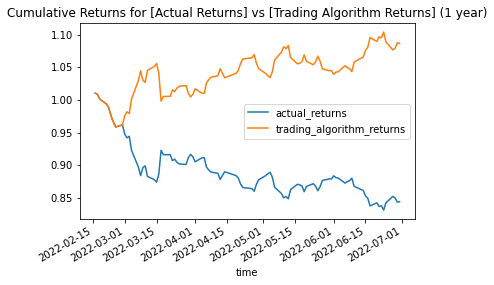

In [15]:
# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot(title = "Cumulative Returns for [Actual Returns] vs [Trading Algorithm Returns] (1 year)")